<a href="https://colab.research.google.com/github/devbyjoaos/Cha-de-bebe-Front/blob/master/IndentificadorDeRelogiosApresentacao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://raw.githubusercontent.com/fzampirolli/morph/main/morph.py
from morph import *

import numpy as np
import cv2
import scipy.signal
from matplotlib import pyplot as plt
import pandas as pd

from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
from datetime import datetime
from IPython.display import Image
import os
import time


--2025-05-07 18:47:31--  https://raw.githubusercontent.com/fzampirolli/morph/main/morph.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42991 (42K) [text/plain]
Saving to: ‘morph.py.5’

morph.py.5          100%[===================>]  41.98K  --.-KB/s    in 0.009s  

2025-05-07 18:47:31 (4.63 MB/s) - ‘morph.py.5’ saved [42991/42991]



#Definir posição da câmera


<IPython.core.display.Javascript object>

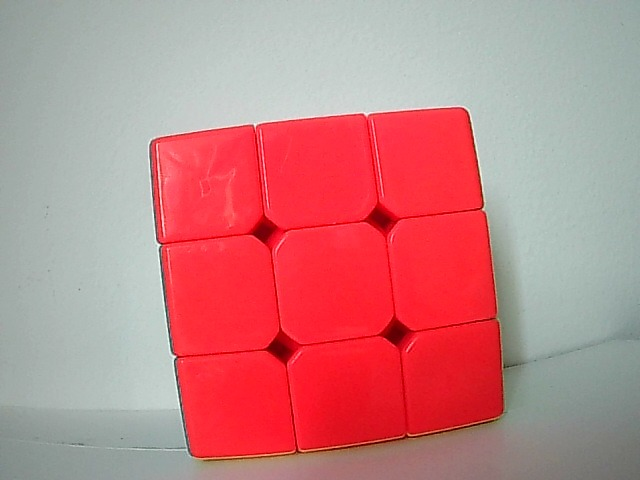

In [ ]:
def take_photo_position(filename, quality):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

image_path = "/content/"
filename=os.path.join(image_path,'vitrine.jpg')
quality=0.8
try:
  take_photo_position(filename, quality)
  display(Image(filename))
except Exception as err:
  print(str(err))

#Definição das funções e variáveis auxiliares



In [ ]:
def take_photo(filename, quality):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename



def blur(img):
  blured_image = cv2.medianBlur(img, 11)
  return blured_image

def binary(img):
  gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
  return thresh


def noise_removal(thresh):
  # Remoção de Ruído
  kernel = np.zeros((6,6),np.uint8)
  kernel[:, 2:4] = 1
  print(kernel)
  opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 1)
  sure_bg = cv2.dilate(opening,kernel,iterations=5)
  return sure_bg

def fore_ground(sure_bg):
  dist_transform = cv2.distanceTransform(sure_bg,cv2.DIST_L2, 0)
  ret, sure_fg = cv2.threshold(dist_transform,0.3*dist_transform.max(),255,0)
  sure_fg = np.uint8(sure_fg)
  return sure_fg

def suround(sure_fg):
  mm.lblshow(sure_fg)

def enumerate_count(img, sure_fg):
  font = cv2.FONT_HERSHEY_DUPLEX
  img_canny = cv2.Canny(img, 100, 200)
  cont, _ = cv2.findContours(sure_fg, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

  color_img = cv2.cvtColor(sure_fg, cv2.COLOR_GRAY2RGB)
  contador = 0
  for k,c in enumerate(cont):
      contador+=1
      x,y,w,h = cv2.boundingRect(c)
      cv2.putText(color_img, str(k+1),(x+w//3, y+h//2), font, 1,(255,0,0),1,cv2.LINE_AA)

  plt.figure(figsize=(15,6))
  plt.imshow(color_img,"gray"),plt.title('Enumaração')
  plt.show()
  return contador

def update_csv(contador):
  try:
    df = pd.read_csv("Prateleiras.csv", usecols=['Numero da prateleira', 'Quantidade de produtos', 'Data'])
  except Exception as e:
    df = pd.DataFrame()

  time = datetime.now()
  dfAux = pd.DataFrame(data={"Numero da prateleira":[1], "Quantidade de produtos":[contador],"Data": [time.strftime("%d/%M/%Y - %H:%m:%S")]})
  df = pd.concat([df, dfAux], ignore_index = True)
  print(df)
  df.to_csv("Prateleiras.csv")

#Execução:

<IPython.core.display.Javascript object>

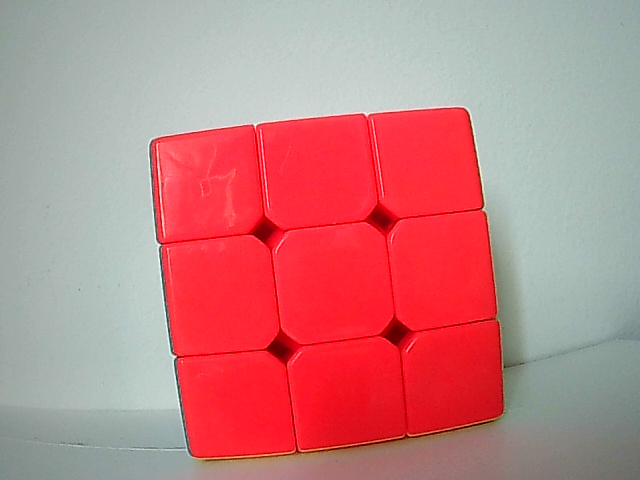

[[0 0 1 1 0 0]
 [0 0 1 1 0 0]
 [0 0 1 1 0 0]
 [0 0 1 1 0 0]
 [0 0 1 1 0 0]
 [0 0 1 1 0 0]]


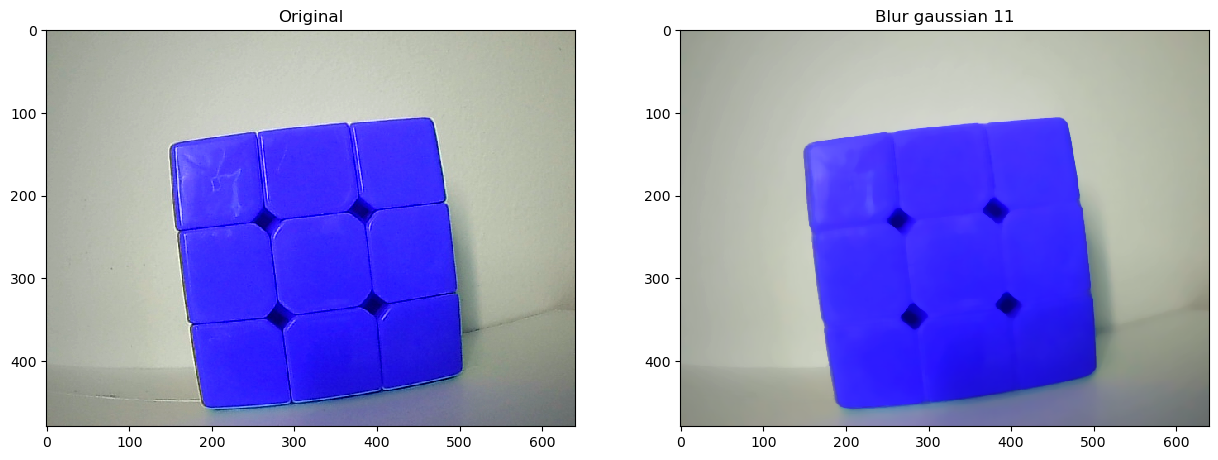

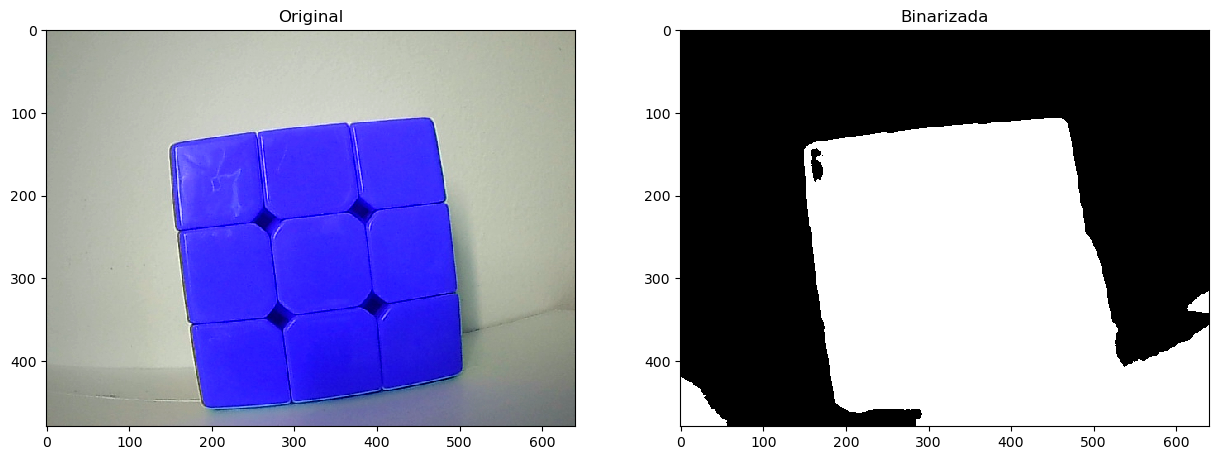

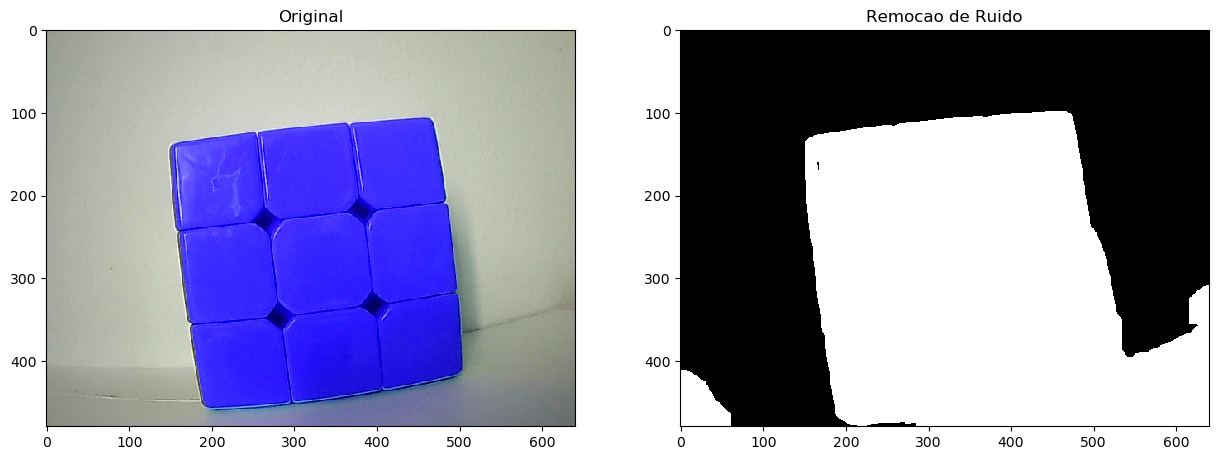

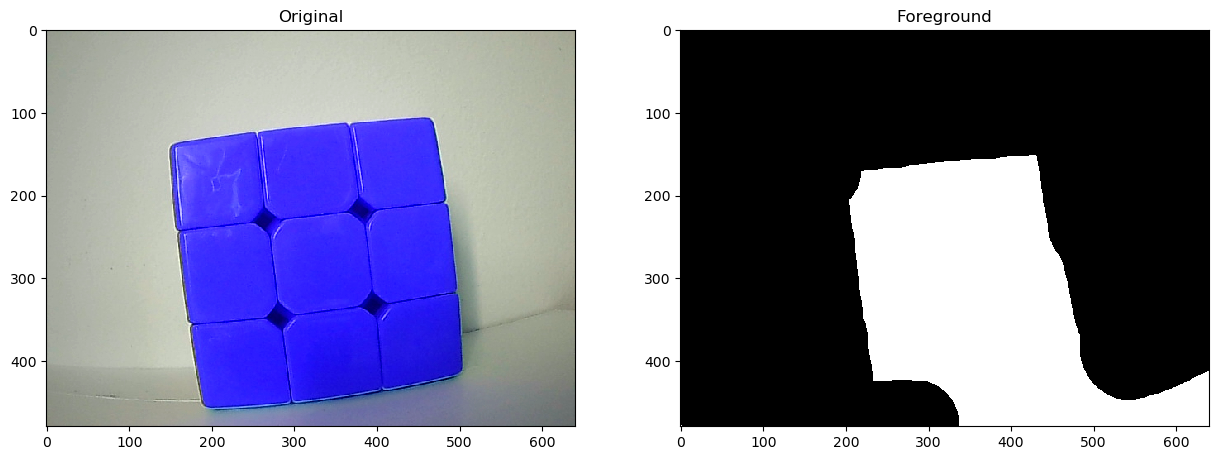

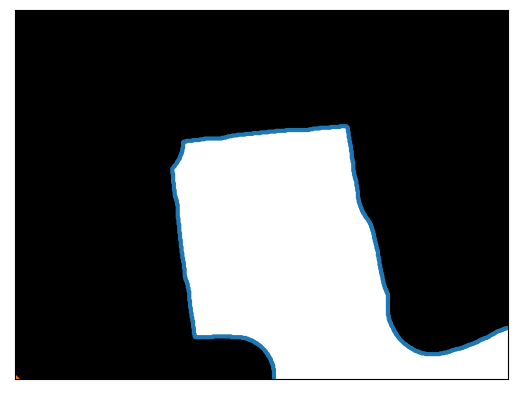

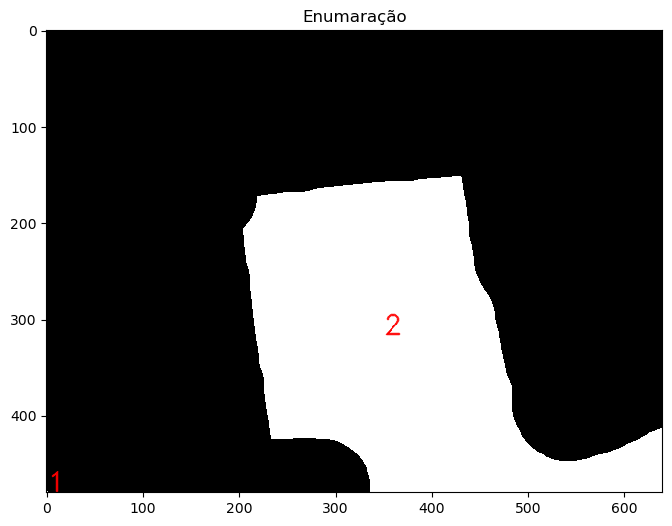

    Numero da prateleira  Quantidade de produtos                   Data
0                      1                       5  07/04/2025 - 18:05:14
1                      1                       5  07/05/2025 - 18:05:48
2                      1                       5  07/05/2025 - 18:05:56
3                      1                       5  07/12/2025 - 18:05:14
4                      1                       5  07/12/2025 - 18:05:22
5                      1                       5  07/13/2025 - 18:05:17
6                      1                       5  07/13/2025 - 18:05:24
7                      1                       5  07/15/2025 - 18:05:57
8                      1                       5  07/16/2025 - 18:05:05
9                      1                       5  07/17/2025 - 18:05:45
10                     1                       5  07/17/2025 - 18:05:57
11                     1                       2  07/18/2025 - 18:05:36
12                     1                       1  07/19/2025 - 1

<IPython.core.display.Javascript object>

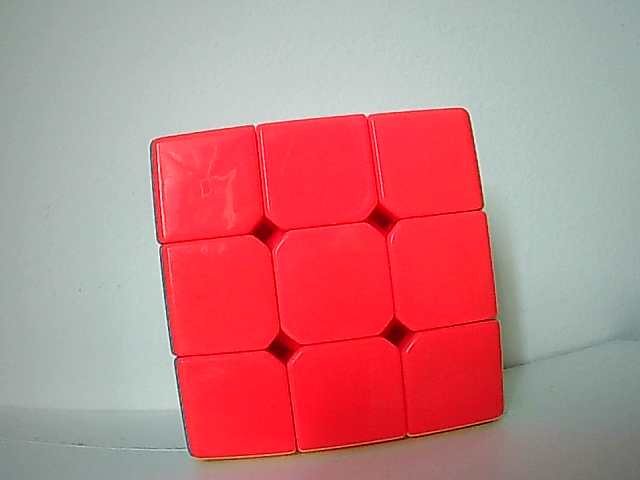

[[0 0 1 1 0 0]
 [0 0 1 1 0 0]
 [0 0 1 1 0 0]
 [0 0 1 1 0 0]
 [0 0 1 1 0 0]
 [0 0 1 1 0 0]]


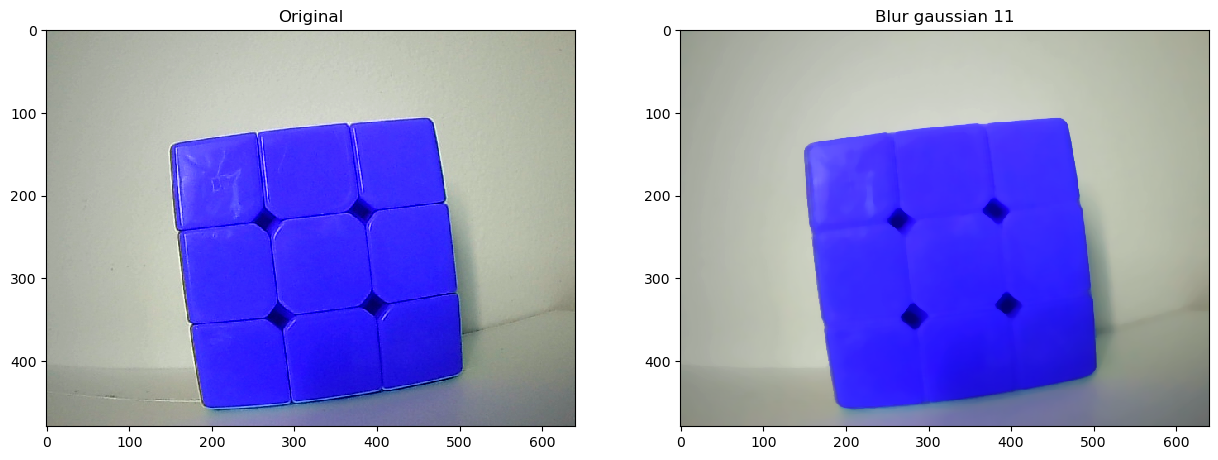

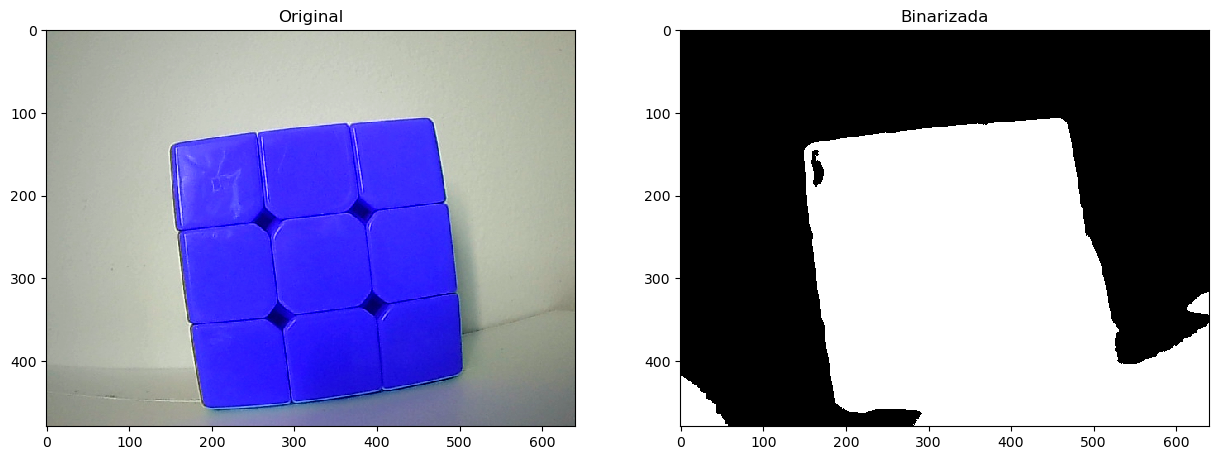

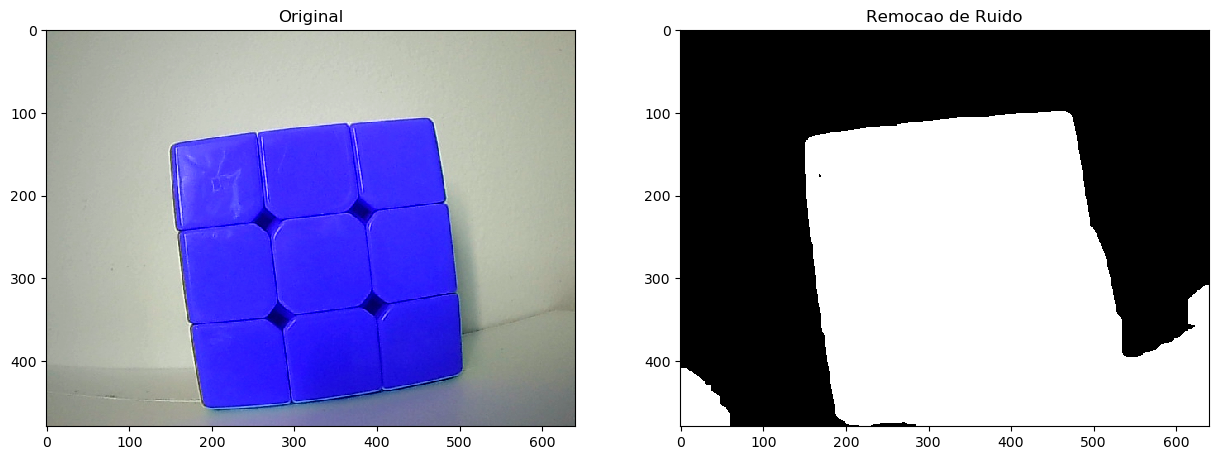

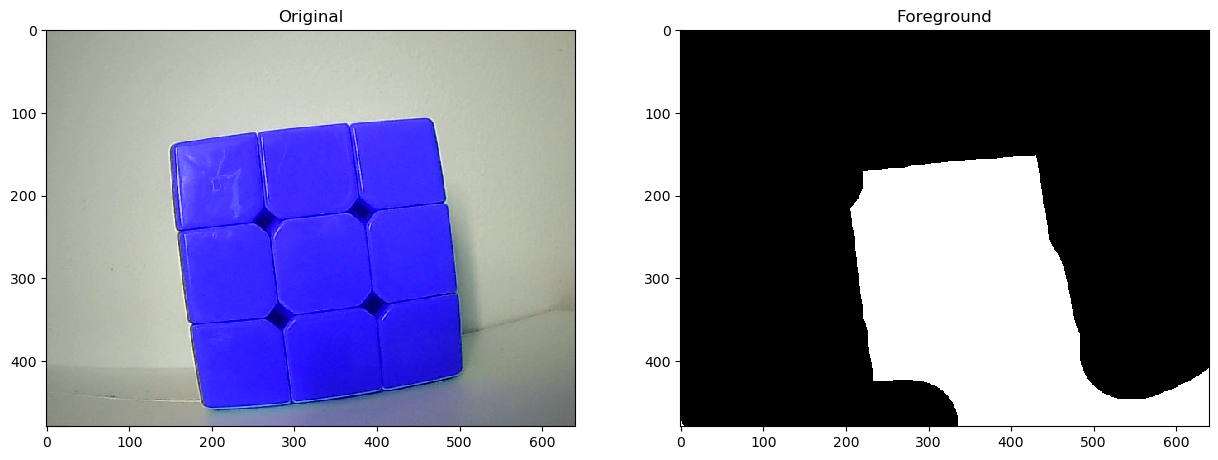

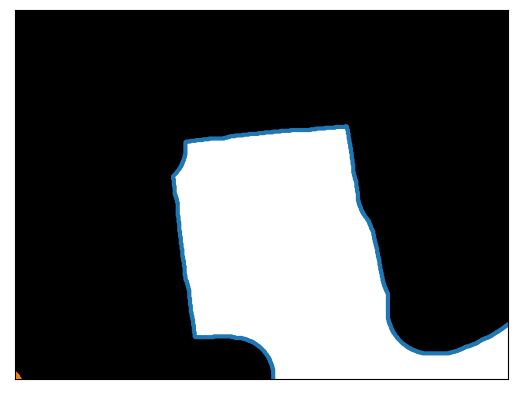

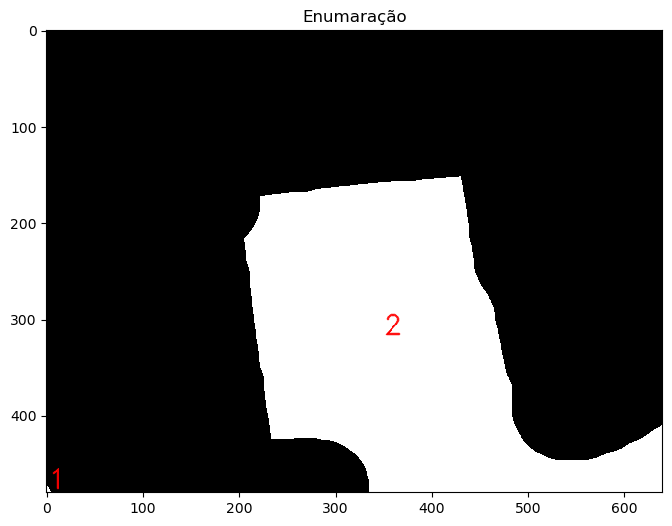

    Numero da prateleira  Quantidade de produtos                   Data
0                      1                       5  07/04/2025 - 18:05:14
1                      1                       5  07/05/2025 - 18:05:48
2                      1                       5  07/05/2025 - 18:05:56
3                      1                       5  07/12/2025 - 18:05:14
4                      1                       5  07/12/2025 - 18:05:22
5                      1                       5  07/13/2025 - 18:05:17
6                      1                       5  07/13/2025 - 18:05:24
7                      1                       5  07/15/2025 - 18:05:57
8                      1                       5  07/16/2025 - 18:05:05
9                      1                       5  07/17/2025 - 18:05:45
10                     1                       5  07/17/2025 - 18:05:57
11                     1                       2  07/18/2025 - 18:05:36
12                     1                       1  07/19/2025 - 1

In [ ]:
for x in range(1,3):

  image_path = "/content/"
  filename=os.path.join(image_path,'vitrine.jpg')
  quality=0.8
  try:
    take_photo(filename, quality)
    display(Image(filename))
  except Exception as err:
    print(str(err))

  img = cv2.imread('vitrine.jpg')

  blured_image = blur(img)
  thresh = binary(blured_image)
  sure_bg = noise_removal(thresh)
  sure_fg = fore_ground(sure_bg)

  plt.figure(figsize=(15,6))
  plt.subplot(121),plt.imshow(img,"gray"),plt.title('Original')
  plt.subplot(122),plt.imshow(blured_image,"gray"),plt.title('Blur gaussian 11')
  plt.show()

  plt.figure(figsize=(15,6))
  plt.subplot(121),plt.imshow(img,"gray"),plt.title('Original')
  plt.subplot(122),plt.imshow(thresh,"gray"),plt.title('Binarizada')
  plt.show()

  plt.figure(figsize=(15,6))
  plt.subplot(121),plt.imshow(img,"gray"),plt.title('Original')
  plt.subplot(122),plt.imshow(sure_bg,"gray"),plt.title('Remocao de Ruido')
  plt.show()

  plt.figure(figsize=(15,6))
  plt.subplot(121),plt.imshow(img,"gray"),plt.title('Original')
  plt.subplot(122),plt.imshow(sure_fg,"gray"),plt.title('Foreground')
  plt.show()

  suround(sure_fg)
  contador = enumerate_count(img, sure_fg)
  update_csv(contador)
  time.sleep(5)

